# Financial Sentiment analysis with article headlines

The dataset I'm using, along with it's description is available here: https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news.

It contains 4837 Financial news headlines with their sentiment (Positive, negative ,neutral).

In this project, I develop and train a LSTM model to classify the headlines.

Since only the headlines with positive or negative sentiment provide useful information for a trading strategy for example, My objective here will be to optimize the precision and recall of of these two classes (and not worry too much about the neutral class). My emphasis will be on the precision since too many false positives for the two classes of interest would probably erase the benefits of detecting them correctly.



In [2]:
#Importing useful libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import torch
import re
import tensorflow as tf
import string
import seaborn as sns

from torch import nn

#the following two functions will allow to ignore padding of the input passed to the neural network
from torch.nn.utils.rnn import pack_padded_sequence 
from torch.nn.utils.rnn import pad_packed_sequence

import nltk
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

2022-01-31 14:38:01.424206: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


I) Data loading and preprocessing

In [4]:
# Loading the dataset and displaying it's first rows
data = pd.read_csv('alldata.csv',delimiter=',',encoding='latin-1')
data.head(10)

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
5,positive,"For the last quarter of 2010 , Componenta 's n..."
6,positive,"In the third quarter of 2010 , net sales incre..."
7,positive,Operating profit rose to EUR 13.1 mn from EUR ...
8,positive,"Operating profit totalled EUR 21.1 mn , up fro..."
9,positive,TeliaSonera TLSN said the offer is in line wit...


In [5]:
# Giving names to the dataset columns
data.columns = ['label','text']
data = data.sample(frac =1)
data.head(10)

,label,text
2365,neutral,A total of 185 Wonderware Certified SIs are av...
3050,neutral,No financial details were revealed .
1973,neutral,An appeal concerning the project has been lodg...
4321,neutral,"In the spring 2006 , a total of 386,530 Stock ..."
2590,neutral,"The buyer is real estate owner Propertos Oy , ..."
4459,positive,Efore 's results for the last quarter showed a...
1625,neutral,The corrected chapter is in its entirety below .
155,positive,Also Lemmink+Æinen 's profit for accounting pe...
4176,negative,"As a result , 12 people will be made redundant..."
2516,neutral,Neste Shipping is the most likely to remain Fi...


In [6]:
#Checking for duplicates
data.text.duplicated().sum()

8

In [7]:
# Droping the duplicates
data = data.drop_duplicates(subset = ['text'], keep = 'first')
data.text.duplicated().sum()

0

In [8]:
# Checking for missing values
data.isna().sum()

label    0
text     0
dtype: int64

In [9]:
# splitting training and testing data. I use 70% of the data for training and 30% for testing
train_data=data.sample(frac=0.7,random_state=200) #random state is a seed value
test_data=data.drop(train_data.index)


/home/jovyan/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


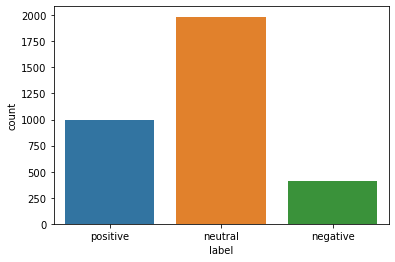

In [10]:
#Checking for class imbalance in the training set
g = sns.countplot(train_data['label'])
plt.show()

The training set is highly imbalanced. I'll deal with it by oversampling (i.e replicate some values in the negative and positive class to match the size of the neutral class ).

/home/jovyan/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


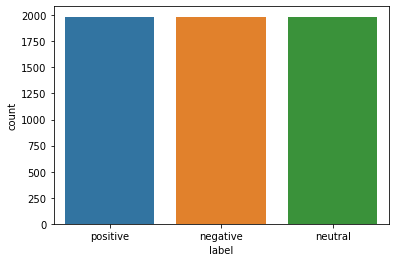

In [11]:
positive_class = train_data[train_data['label'] == 'positive']
positive_count = train_data['label'].value_counts()['positive'] # will be useful during model testing
negative_class = train_data[train_data['label'] == 'negative']
negative_count = train_data['label'].value_counts()['negative'] # wiil be useful during model testing
neutral_class = train_data[train_data['label'] == 'neutral']
neutral_count = train_data['label'].value_counts()['neutral']

positive_class_over = positive_class.sample(neutral_count, replace=True)
negative_class_over = negative_class.sample(neutral_count, replace=True)
train_data = pd.concat([positive_class_over, negative_class_over,neutral_class], axis=0)

g = sns.countplot(train_data['label'])
plt.show()

Now, we have a balanced dataset. 

In [12]:
# I recombine the training and testing sets
data = pd.concat([train_data, test_data], axis=0)

Now I will preprocess and tokenize the sentences (i.e convert them to list of words).I'll also examine some characteristics of the dataset (sentence lengths, number of unique words).

The number of unique words is: 10139


<AxesSubplot:>

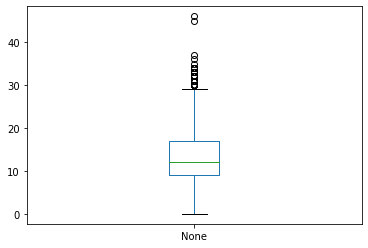

In [13]:
head_list = data['text'].tolist() # list of headlines


# Importing libraries and initializing objects for the preprocessing and tokenization
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess and tokenize a sentence
def nltk_tokenizer(headline):
    #For the different steps of preprocessing, see this kaggle notebook https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing
    
    #URLs removal
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    headline = url_pattern.sub(r'', headline)
    
    #HTML removal
    html_pattern = re.compile('<.*?>')
    headline= html_pattern.sub(r'', headline)
    
    #Punctuation removal
    Punctuation = string.punctuation
    headline = headline.translate(str.maketrans('', '', Punctuation))
    
    #Tokenization
    head_tokens = word_tokenize(headline)    
    
    #stop words removal
    head_tokens = [token for token in head_tokens if not (token.lower() in stop_words) ] 
    
    #Lemmatization and conversion to lowercase
    head_tokens = [lemmatizer.lemmatize(token.lower()) for token in head_tokens]
    
    return head_tokens

# Applying the the tokenization function to the headlines
head_list_token = [nltk_tokenizer(headline) for headline in head_list]

#Creating a list of the words in the dataset and counting the unique words
words_list = head_list_token[0]
for headline in head_list_token:
    words_list = words_list+headline
words_count = len(set(words_list)) #Number of unique words in the dataset
print("The number of unique words is:", words_count)

lenlist = pd.Series([len(headline) for headline in head_list_token]) #lengths of the headlines in the dataset
lenlist.plot(kind='box') #box plot for the headlines lengths

Looks like just a couple of headlines have more than 30 words

In [14]:
i = 0
for headline in head_list_token:
    if len(headline) > 30:
        #print(" ".join(review))
        i += 1
print("The proportion of reviews with more than 30 words is:", (i/len(head_list_token))*100,"%")

The proportion of reviews with more than 30 words is: 0.9852881630449454 %


The LSTM model requires all the inputs (sentences) to have the same length. Therefore some sentences will need to be padded and others truncated. The sentence length I set will impact the running time of the model, so I need it to be as small as possible without too much impact on the dataset.
Since only a few words have a length higher than 30, I'll set a sentence length of 30.

I create dataset objects to train and test the model. I convert the original dataset to an appropriate format to pass to the model.

In [15]:

head_list = [" ".join(headline) for headline in head_list_token] #Putting the tokenized sentences back together

# Creating a tokenizer object. This object will facilitate the conversion of the dataset to it's numeric representation
max_words = int(words_count*0.8)# Number of most frequent words to use for the tokenization
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words = max_words,split=" ") 
tokenizer.fit_on_texts(head_list) 


# Converting word to indices
indice_lists = tokenizer.texts_to_sequences(head_list) #each review is converted to a list of integer, where an integer is the indice of the coresponding word in the vocabulary
indice_lists_pad = tf.keras.preprocessing.sequence.pad_sequences(indice_lists, maxlen=30,padding='pre',truncating='post', value=0.0) #add zeros for all the lists to have the same length. and truncate reviews that are too long.
indice_lists_pad = torch.Tensor.long(torch.from_numpy(indice_lists_pad)) #converting the padded sequences to a tensor


# Converting labels to numeric values
label_list = data['label'].tolist()
label_dict = {"positive":0,"negative":1,"neutral":2}
label_list = torch.tensor( [label_dict[element] for element in label_list])


split = train_data.shape[0] #where to split between training and testing set.
# Note: There hasn't been any shuffling of the data so we'll have the same testing and training set we had before.


from torch.utils.data import Dataset

# Training set object
class training_data(Dataset):
    def __init__(self):
        self.samples = [indice_lists_pad[:split,:],label_list[:split]]
        #self.samples = self.samples.to(device)

    def __len__(self):
        return self.samples[1].size()[0]

    def __getitem__(self, idx):
        return self.samples[0][idx,:],self.samples[1][idx]

# Testing set object
class testing_data(Dataset):
    def __init__(self):
        self.samples = [indice_lists_pad[split:,:],label_list[split:]]
        #self.samples = self.samples.to(device)

    def __len__(self):
        return self.samples[1].size()[0]

    def __getitem__(self, idx):
        return self.samples[0][idx,:],self.samples[1][idx]

In [16]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data(), batch_size=200)
test_dataloader = DataLoader(testing_data(), batch_size=200)

In [17]:
# numbers of positive,negative and neutral labels in the testing set. Those will be useful to compute certain metrics during the training.
test_pos_count = (label_list[split:] == 0).type(torch.float).sum().item()
test_neg_count = (label_list[split:] == 1).type(torch.float).sum().item()
test_neut_count =(label_list[split:] == 2).type(torch.float).sum().item()

In [18]:
#number of unique indices
max_words+1 #+1 for 0 which represents the padding

8112

Passing sentences to a classification model involves a step called embedding. The words are converted to numerical vectors with values based on the context in which the words are used and their similarity with other words.

There are pretrained word embeddings, i.e vector representation of words learned on another (typically large) dataset. 
Our dataset is very small (only 4837 values), so it'll fail to capture many of the specifics of the human language (I actually tried without pretrained embedding and the results were very bad). An embedding pretrained on a large dataset better capture the structure of the language. It can be used as a baseline and be updated during the training of the model to adapt to a specific context (here the financial context).

For this project, I'll use a pretrained embedding called glove https://nlp.stanford.edu/projects/glove/

In [19]:
# Loading a pretrained word embedding (the vectors are 50 dimensional)
glove = pd.read_csv('glove.6B.50d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove.head(10)

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,,,,,,,,,,,,,,,,,,,,,
the,0.418000,0.249680,-0.41242,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.000660,-0.656600,...,-0.298710,-0.157490,-0.347580,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.115140,-0.785810
",",0.013441,0.236820,-0.16899,0.409510,0.638120,0.477090,-0.42852,-0.556410,-0.364000,-0.239380,...,-0.080262,0.630030,0.321110,-0.467650,0.227860,0.360340,-0.378180,-0.566570,0.044691,0.303920
.,0.151640,0.301770,-0.16763,0.176840,0.317190,0.339730,-0.43478,-0.310860,-0.449990,-0.294860,...,-0.000064,0.068987,0.087939,-0.102850,-0.139310,0.223140,-0.080803,-0.356520,0.016413,0.102160
of,0.708530,0.570880,-0.47160,0.180480,0.544490,0.726030,0.18157,-0.523930,0.103810,-0.175660,...,-0.347270,0.284830,0.075693,-0.062178,-0.389880,0.229020,-0.216170,-0.225620,-0.093918,-0.803750
to,0.680470,-0.039263,0.30186,-0.177920,0.429620,0.032246,-0.41376,0.132280,-0.298470,-0.085253,...,-0.094375,0.018324,0.210480,-0.030880,-0.197220,0.082279,-0.094340,-0.073297,-0.064699,-0.260440
and,0.268180,0.143460,-0.27877,0.016257,0.113840,0.699230,-0.51332,-0.473680,-0.330750,-0.138340,...,-0.069043,0.368850,0.251680,-0.245170,0.253810,0.136700,-0.311780,-0.632100,-0.250280,-0.380970
in,0.330420,0.249950,-0.60874,0.109230,0.036372,0.151000,-0.55083,-0.074239,-0.092307,-0.328210,...,-0.486090,-0.008027,0.031184,-0.365760,-0.426990,0.421640,-0.116660,-0.507030,-0.027273,-0.532850
a,0.217050,0.465150,-0.46757,0.100820,1.013500,0.748450,-0.53104,-0.262560,0.168120,0.131820,...,0.138130,0.369730,-0.642890,0.024142,-0.039315,-0.260370,0.120170,-0.043782,0.410130,0.179600
"""",0.257690,0.456290,-0.76974,-0.376790,0.592720,-0.063527,0.20545,-0.573850,-0.290090,-0.136620,...,0.030498,-0.395430,-0.385150,-1.000200,0.087599,-0.310090,-0.346770,-0.314380,0.750040,0.970650


In [20]:
# storing words and their vector representations in a dictionnary
glove_embedding = {key: val.values for key, val in glove.T.items()} # dictionarry of word:vector representation pairs(the vectors are numpy arrays)

I create an embedding matrix, i.e a matrix pairing each word in the dataset vocabulary to it's vector embedding (Glove). It's used for the embedding during the model training.

In [21]:

vocab = tokenizer.word_index

# Function to create the embedding matrix
def create_embedding_matrix(vocab,embedding_dict):
    embedding_matrix=np.random.rand(len(vocab)+1,50) 
    
    for word,index in vocab.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix
   
#embedding matrix   
embedding_matrix=create_embedding_matrix(vocab,embedding_dict=glove_embedding) 
embedding_matrix = torch.from_numpy(embedding_matrix)
embedding_matrix = embedding_matrix .to(device)



II) Model development (LSTM)

In [22]:
# Function to create an embedding layer
def create_emb_layer(embedding_matrix, non_trainable=False):
    num_embeddings, embedding_dim = embedding_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim,padding_idx=0,device=device) #padding_idx = 0 means that all elements equal to zero in the input correpond to padding
    emb_layer.load_state_dict({'weight': embedding_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = True
    
    return emb_layer


#LSTM
class myLSTM(nn.Module):
    def __init__(self,input_size,hidden_size,embedding_matrix): # Data is inputed in the neural network by minibatches.
        super(myLSTM, self).__init__()
        self.input_size = input_size #dimension of xi(vector representation of words)
        self.hidden_size = hidden_size #dimension of states St
        self.embedding_matrix = embedding_matrix
        
        
        self.embed = create_emb_layer(self.embedding_matrix,False) 
        
        # RNN layer
        self.lstm = nn.LSTM(input_size,hidden_size,batch_first = True)
        
        # Logistic regression layer
        self.linear = nn.Linear(hidden_size,3) #this will be applied to each element of the batch. No need to specify the size of the batch
        self.softmax = nn.Softmax(dim = 1) 
             #returns a vector of probabilities
             #there are 3 categories: positive, negative, neutral (The probabilities for the 3 classes are returned)
        
    def forward(self, x,batch_size):
       
        
        #print(batch_size)
        h_0 = torch.zeros(1,batch_size,self.hidden_size).to(device)
        c_0 = torch.randn(1,batch_size,self.hidden_size).to(device)
        
        x = x.to(device)
        e = self.embed(x)
        
        
        e = e.to(device)
        
        
        
        r = self.lstm(e,(h_0,c_0))
        
        logits = self.softmax(self.linear(r[1][0]))
        
        return logits
    

III) Training and testing

1) Training and testing functions

In [23]:
# Training and testing loop setup

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer,printer = False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        Y = torch.unsqueeze(y,1)
        Y = Y.to(device)
        pred = torch.squeeze(model(X,y.size()[0]),0)

        
        loss = loss_fn(pred,torch.squeeze(Y,1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            if printer:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Test loop
def test_loop(dataloader, model, loss_fn,test_pos_count,test_neg_count,test_neut_count,printer = False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    #test_loss, correct = 0, 0
    test_loss = 0
    true_pos,true_neg,true_neut,predicted_pos,predicted_neg,predicted_neut = 0,0,0,0,0,0

    with torch.no_grad():
        for X, y in dataloader:
            Y = torch.unsqueeze(y,1)
            Y = Y.to(device)
            pred = torch.squeeze(model(X,y.size()[0]),0)
            
            
            
            test_loss += loss_fn(pred,torch.squeeze(Y,1)).item()
            
            #correct += (pred.argmax(1) == torch.squeeze(Y)).type(torch.float).sum().item()
            true_pos += (pred.argmax(1)[ pred.argmax(1)== torch.squeeze(Y)] == 0).type(torch.float).sum().item()
            true_neg += (pred.argmax(1)[ pred.argmax(1)== torch.squeeze(Y)] == 1).type(torch.float).sum().item()
            true_neut += (pred.argmax(1)[ pred.argmax(1)== torch.squeeze(Y)] == 2).type(torch.float).sum().item()
            predicted_pos += (pred.argmax(1)==0).type(torch.float).sum().item()
            predicted_neg += (pred.argmax(1)==1).type(torch.float).sum().item()
            predicted_neut += (pred.argmax(1)==2).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    
    # Positive class performance
    pos_precision = true_pos/predicted_pos
    pos_recall = true_pos/ test_pos_count
    
    # Negative class performance
    neg_precision = true_neg/predicted_neg
    neg_recall = true_neg / test_neg_count
    
    # Neutral class performance
    neut_precision = true_neut/predicted_neut
    neut_recall = true_neut/ test_neut_count
    
    
    
    
    
    
    if printer:
        #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        print(f"Positive precision: {(100*pos_precision):>0.1f}%\n")
        print(f"Positive recall: {(100*pos_recall):>0.1f}%\n\n")
        print(f"Negative precision: {(100*neg_precision):>0.1f}%\n")
        print(f"Negative recall: {(100*neg_recall):>0.1f}%\n\n")
        #print(f"Neutral precision: {(100*neut_precision):>0.1f}%\n")
        #print(f"Neutral recall: {(100*neut_recall):>0.1f}%\n")
    return pos_precision,pos_recall,neg_precision,neg_recall,neut_precision,neut_recall

2) Training and testing

a) Phase 1 (No weights for class imbalance)

Epoch 1
-------------------------------
loss: 1.098612  [    0/ 5982]
Positive precision: 24.5%

Positive recall: 32.9%


Negative precision: 16.5%

Negative recall: 42.2%


Epoch 2501
-------------------------------
loss: 1.098633  [    0/ 5982]
Positive precision: 25.0%

Positive recall: 54.4%


Negative precision: 24.9%

Negative recall: 51.0%


Done!


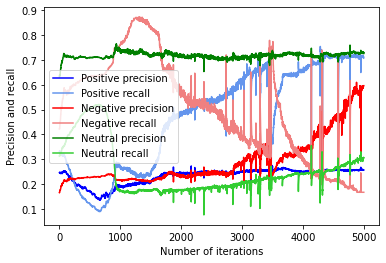

In [31]:
i_size = 50 # input size
h_dim = 50 #hidden size

mylstm = myLSTM(input_size = i_size,hidden_size = h_dim,embedding_matrix=embedding_matrix).to(device)
 

    
    
## Training and testing

# Hyperparameters
learning_rate = 5
batch_size = 200
epochs = 5000

#l_errors = [0]*epochs #will store classification errors
pos_precisions = [0]*epochs
pos_recalls = [0]*epochs
neg_precisions = [0]*epochs
neg_recalls = [0]*epochs
neut_precisions = [0]*epochs
neut_recalls = [0]*epochs

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()



# specifying that the optimizer is stochastic gradient descent
optimizer = torch.optim.SGD(mylstm.parameters(), lr=learning_rate)


#Training and testing
for t in range(epochs):
    if t%2500==0:
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, mylstm, loss_fn, optimizer,True)
        pos_precisions[t],pos_recalls[t],neg_precisions[t],neg_recalls[t],neut_precisions[t],neut_recalls[t] = test_loop(test_dataloader, mylstm, loss_fn,test_pos_count,test_neg_count,test_neut_count,True)
    else:
        train_loop(train_dataloader, mylstm, loss_fn, optimizer)
        pos_precisions[t],pos_recalls[t],neg_precisions[t],neg_recalls[t],neut_precisions[t],neut_recalls[t] = test_loop(test_dataloader, mylstm, loss_fn,test_pos_count,test_neg_count,test_neut_count)
    
print("Done!")


# Plotting
plt.plot(range(1,epochs+1),pos_precisions,label = "Positive precision", color = 'b')
plt.plot(range(1,epochs+1),pos_recalls,label = "Positive recall", color = 'cornflowerblue')
plt.plot(range(1,epochs+1),neg_precisions,label = "Negative precision", color = 'r')
plt.plot(range(1,epochs+1),neg_recalls,label = "Negative recall", color = 'lightcoral')
plt.plot(range(1,epochs+1),neut_precisions,label = "Neutral precision", color = 'g')
plt.plot(range(1,epochs+1),neut_recalls,label = "Neutral recall", color = 'limegreen')
plt.xlabel("Number of iterations")
plt.ylabel("Precision and recall")
plt.legend()
plt.show()



            

The precision of the positvetive class is very low (less than 30%) and doesn't seem to improve. 

My objective was to maximize the precision and recall (with emphasis on the precision) of both the positive and negative classes. So the obtained result are not satisfactory.

I'll put weights in the loss function in order to penalize more misclassification errors for the positive and negative classes and hopefully get better results for these classes. The weight for a given class will be the inverse of it's sample size

b) Phase 2 (weights for class imbalance)

Epoch 1
-------------------------------
loss: 1.098613  [    0/ 5982]
Positive precision: 21.9%

Positive recall: 25.3%


Negative precision: 14.0%

Negative recall: 30.9%


Epoch 2501
-------------------------------
loss: 1.098634  [    0/ 5982]
Positive precision: 23.9%

Positive recall: 36.1%


Negative precision: 21.6%

Negative recall: 76.5%


Done!


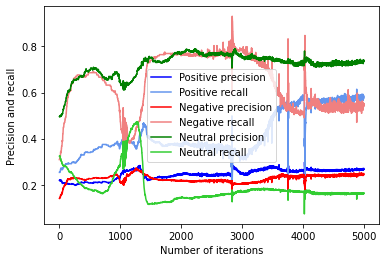

In [32]:
i_size = 50 # input size
h_dim = 50 #hidden size

mylstm = myLSTM(input_size = i_size,hidden_size = h_dim,embedding_matrix=embedding_matrix).to(device)
 

    
    
## Training and testing

# Hyperparameters
learning_rate = 5
batch_size = 200
epochs = 5000

#l_errors = [0]*epochs #will store classification errors
pos_precisions = [0]*epochs
pos_recalls = [0]*epochs
neg_precisions = [0]*epochs
neg_recalls = [0]*epochs
neut_precisions = [0]*epochs
neut_recalls = [0]*epochs

# Initialize the loss function

#loss_fn = nn.CrossEntropyLoss(weight = weights)
weights = torch.tensor([1/positive_count,1/negative_count,1/neutral_count]).float().to(device)
loss_fn = nn.CrossEntropyLoss(weight = weights)

#loss_fn = nn.BCELoss()

# specifying that the optimizer is stochastic gradient descent
optimizer = torch.optim.SGD(mylstm.parameters(), lr=learning_rate)
#optimizer =torch.optim.Adam(mylstm.parameters(), lr=learning_rate)

#Training and testing
for t in range(epochs):
    if t%2500==0:
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, mylstm, loss_fn, optimizer,True)
        pos_precisions[t],pos_recalls[t],neg_precisions[t],neg_recalls[t],neut_precisions[t],neut_recalls[t] = test_loop(test_dataloader, mylstm, loss_fn,test_pos_count,test_neg_count,test_neut_count,True)
    else:
        train_loop(train_dataloader, mylstm, loss_fn, optimizer)
        pos_precisions[t],pos_recalls[t],neg_precisions[t],neg_recalls[t],neut_precisions[t],neut_recalls[t] = test_loop(test_dataloader, mylstm, loss_fn,test_pos_count,test_neg_count,test_neut_count)

print("Done!")


# Plotting
plt.plot(range(1,epochs+1),pos_precisions,label = "Positive precision", color = 'b')
plt.plot(range(1,epochs+1),pos_recalls,label = "Positive recall", color = 'cornflowerblue')
plt.plot(range(1,epochs+1),neg_precisions,label = "Negative precision", color = 'r')
plt.plot(range(1,epochs+1),neg_recalls,label = "Negative recall", color = 'lightcoral')
plt.plot(range(1,epochs+1),neut_precisions,label = "Neutral precision", color = 'g')
plt.plot(range(1,epochs+1),neut_recalls,label = "Neutral recall", color = 'limegreen')
plt.xlabel("Number of iterations")
plt.ylabel("Precision and recall")
plt.legend()
plt.show()



            

The precision is again very low for the positive class (and also for thr negative class this time), with very little improvement during training.
This is probably due to the fact that there's very little data with the positive label.

My initial objective which was getting a good precision and recall for both the positive and negative classes seems impossible to meet given the quality(size) of the dataset. 


May be focusing only on the negative class, and trying to get a good precision and recall on this class might be doable.
In this case It makes more sense to do a binary classification (Negative sentiment against non-negative). 